# Project

## Importing modules

In [3]:
!pip install torchinfo --quiet

In [4]:
import os
import random
import gzip
import pickle
import zipfile
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchinfo import summary
from matplotlib import pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setting seed

In [54]:
# Set the seed for PyTorch
torch.manual_seed(1405)

# Set the seed for NumPy
np.random.seed(1405)

# Set the seed for Python's built-in random library
random.seed(1405)

# If using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(1405)
    torch.cuda.manual_seed_all(1405)  # if you are using multi-GPU.

# Generic functions

The functions and classes here are taken from lab 5 with all the junk removed. They (should) work for any dataset.

In [5]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [6]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [7]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()  # ChatGPT says opt.zero_grad should be first not last?
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [9]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

In [10]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            # Unpack the loss and other outputs
            loss, _ = loss_batch(model, loss_func, xb, yb, opt)
            total_loss += loss
            preds = model(xb).argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss_total, val_correct = 0.0, 0
            val_samples = 0
            for xb, yb in valid_dl:
                # Get validation loss
                val_loss, _ = loss_batch(model, loss_func, xb, yb)

                val_loss_total += val_loss
                preds = model(xb).argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

            val_loss_avg = val_loss_total / len(valid_dl)
            val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss function
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

## Loading MNIST as example

In [12]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://figshare.com/ndownloader/files/25635053"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL).content
        (PATH / FILENAME).open("wb").write(content)

In [13]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

('x_train.shape', (50000, 784))
('y_train.shape', (50000,))


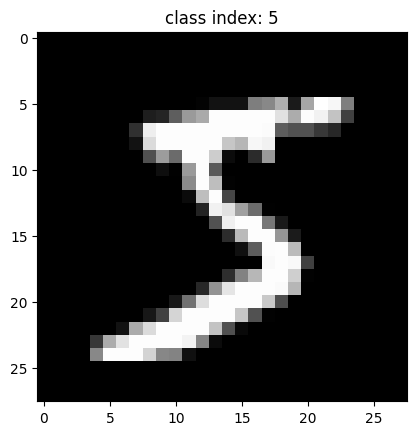

In [14]:
print(('x_train.shape',x_train.shape))
print(('y_train.shape',y_train.shape))

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.title('class index: ' + str(y_train[0]));

### Split data

DataLoader is used to efficiently iterate over the datasets during training. bs is the batch size, set to 64, dictating how many samples are processed at a time.

In [15]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

bs = 64  # batch size
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

Preprocess the data to have shape (-1,1,28,28).

WrappedDataLoader applies the preprocess function to each batch of data.

In [16]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs) #forstår ikke denne. Vi har jo lige defineret train_dl og valid_dl??
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Model

Basic model with batchnormalization (as recommended in Training Convolutional Neural Networks - part 2)

In [17]:
MNIST_model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(10),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

### Train

In [18]:
MNIST_model.to(dev) #Makes device GPU if availbale else it is CPU
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = optim.SGD(MNIST_model.parameters(), lr=lr, momentum=0.9)

Epoch 1/2 - Train Loss: 1.0937, Train Acc: 0.7621 - Val Loss: 0.5645, Val Acc: 0.8857
Epoch 2/2 - Train Loss: 0.4989, Train Acc: 0.8997 - Val Loss: 0.3692, Val Acc: 0.9175


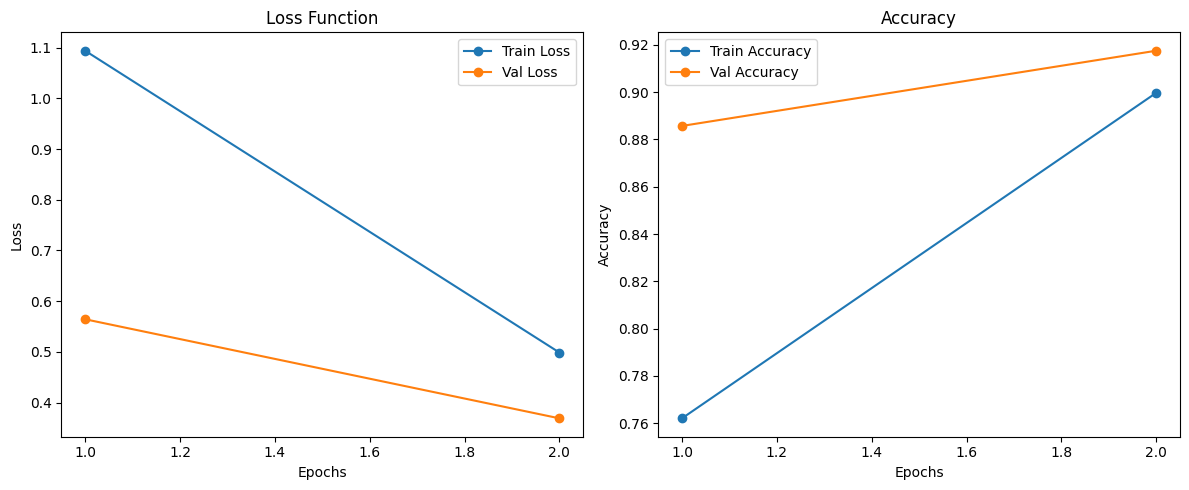

In [19]:
fit(epochs, MNIST_model, loss_func, opt, train_dl, valid_dl)

# Loading German traffic signs

In [20]:
# Path to your ZIP file in Google Drive
zip_file_path = '/content/gdrive/MyDrive/German-traffic-signs/archive.zip'

# Create a directory to extract the contents if it doesn't exist
extract_path = '/content/gtsrb'
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['Train', 'train', 'Test.csv', 'Train.csv', 'Test', 'meta', 'Meta.csv', 'test', 'Meta']


**Define transformation and load into train, test and valdiadation set.**

Note that the test files the classes are hidden. So we just take train files and randomly split into train, test and validation set. Can be confirmed by running this code



```
# Check the contents of the train and test folders
train_files = os.listdir('/content/gtsrb/train')
test_files = os.listdir('/content/gtsrb/test')
print("Train folders:", train_files)
print("Test folders:", test_files)
```



In [21]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
])

# Load the dataset and transform
full_dataset = datasets.ImageFolder(
    root='/content/gtsrb/train',
    transform=transform
)

# Check the total number of samples in the dataset
total_samples = len(full_dataset)
print(f"Total samples in the dataset: {total_samples}")

Total samples in the dataset: 39209


Now we split this into 70% train, 15% validation and 15% test.

In [22]:
# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the lengths for each split
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 27446, Validation size: 5881, Test size: 5882


In [23]:
# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [24]:
# Set the batch size
bs = 64

# Create DataLoaders. A dataloader provides an efficient way to iterate over your dataset during training
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=bs * 2, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=bs * 2, shuffle=False)

## Dataset summary

Show how many classes we have in dataset:

In [25]:
# Get the number of classes from the original dataset (full_dataset)
num_classes = len(full_dataset.classes)

# Print the number of classes
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 43


43 classes

## Visualize the classes

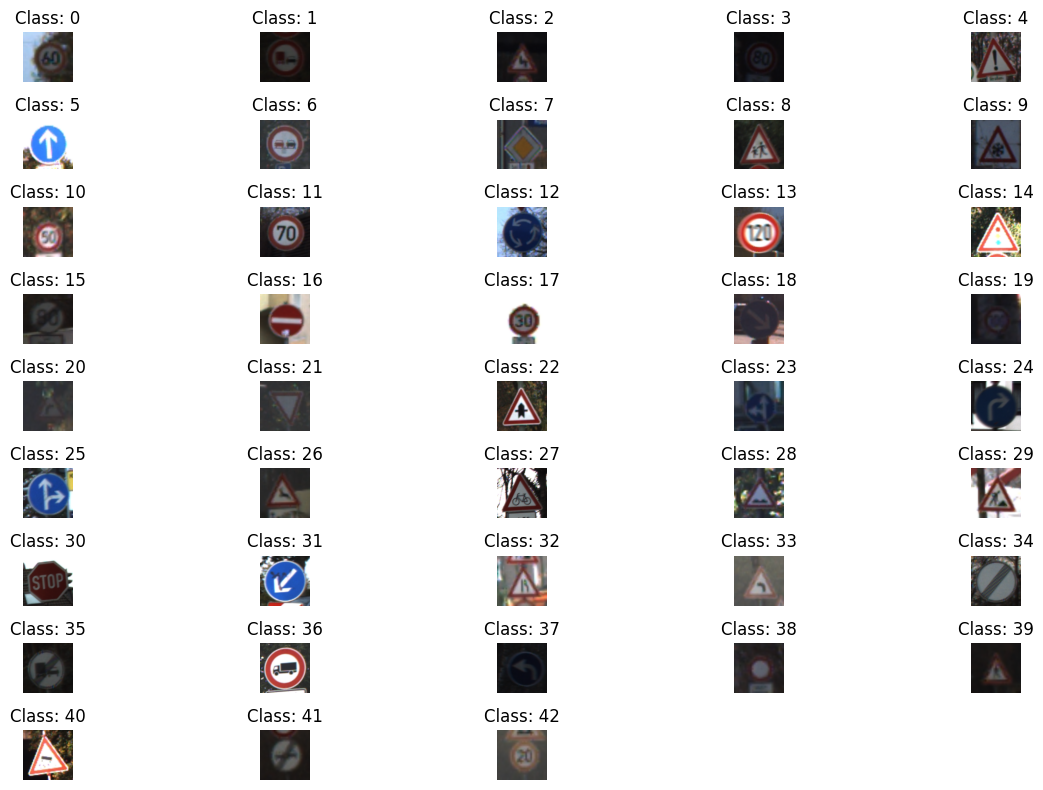

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to show images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  # Undo normalization
    img = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert to HWC format
    plt.axis('off')  # Hide axis

# Create a dictionary to keep track of images displayed for each class
class_count = {i: 0 for i in range(num_classes)}  # Assuming class labels are from 0 to num_classes - 1

# Store images and labels
ordered_images = []
ordered_labels = []

# Get images until one for each class is found
while len(ordered_images) < num_classes:
    dataiter = iter(train_dl)  # Reset the iterator for each pass
    images, labels = next(dataiter)

    # Loop through the images to find and store one per class
    for i in range(len(images)):
        label = labels[i].item()

        # Check if we have already stored an image for this class
        if class_count[label] < 1:  # Change to images_per_class if needed
            ordered_images.append(images[i])  # Store the image
            ordered_labels.append(label)  # Store the label
            class_count[label] += 1  # Increment count for this class

# Plot the images and their corresponding labels in order
ordered_labels = np.sort(ordered_labels)
plt.figure(figsize=(12, 8))
num_images_per_row = 5  # Maximum images per row

# Loop to display images in order
for i, (img, label) in enumerate(zip(ordered_images, ordered_labels)):
    plt.subplot((num_classes + num_images_per_row - 1) // num_images_per_row, num_images_per_row, i + 1)
    imshow(img)
    plt.title(f'Class: {label}')

plt.tight_layout()
plt.show()

## Baseline model

In [38]:
baseline_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),#Used to flatten he output
    #nn.Flatten(), # Flatten the output for the linear layer
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



In [39]:
summary(baseline_model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─ReLU: 1-2                              [1, 16, 80, 80]           --
├─Conv2d: 1-3                            [1, 32, 40, 40]           4,640
├─ReLU: 1-4                              [1, 32, 40, 40]           --
├─Conv2d: 1-5                            [1, 64, 20, 20]           18,496
├─ReLU: 1-6                              [1, 64, 20, 20]           --
├─AdaptiveAvgPool2d: 1-7                 [1, 64, 1, 1]             --
├─Lambda: 1-8                            [1, 64]                   --
├─Linear: 1-9                            [1, 43]                   2,795
Total params: 26,379
Trainable params: 26,379
Non-trainable params: 0
Total mult-adds (M): 17.69
Input size (MB): 0.31
Forward/backward pass size (MB): 1.43
Params size (MB): 0.11
Estimated Total Size (MB): 1.85

### Train baseline model

In [44]:
baseline_model.to(dev) # add to gpu
lr = 0.01
epochs = 3
loss_func = F.cross_entropy
opt = torch.optim.Adam(baseline_model.parameters(), lr=lr) # Adam optimizer

The output is the loss.

Increase speed so only use 25%.

In [45]:
# Grab 25% of the data
subset_indices = random.sample(range(len(train_dataset)), int(0.25 * len(train_dataset)))
subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
train_dl = DataLoader(train_dataset, batch_size=bs, sampler=subset_sampler)

Epoch 1/3 - Train Loss: 3.3577, Train Acc: 0.1026 - Val Loss: 3.4110, Val Acc: 0.0908
Epoch 2/3 - Train Loss: 3.2244, Train Acc: 0.1201 - Val Loss: 3.1800, Val Acc: 0.1081
Epoch 3/3 - Train Loss: 3.0843, Train Acc: 0.1374 - Val Loss: 3.3180, Val Acc: 0.0769


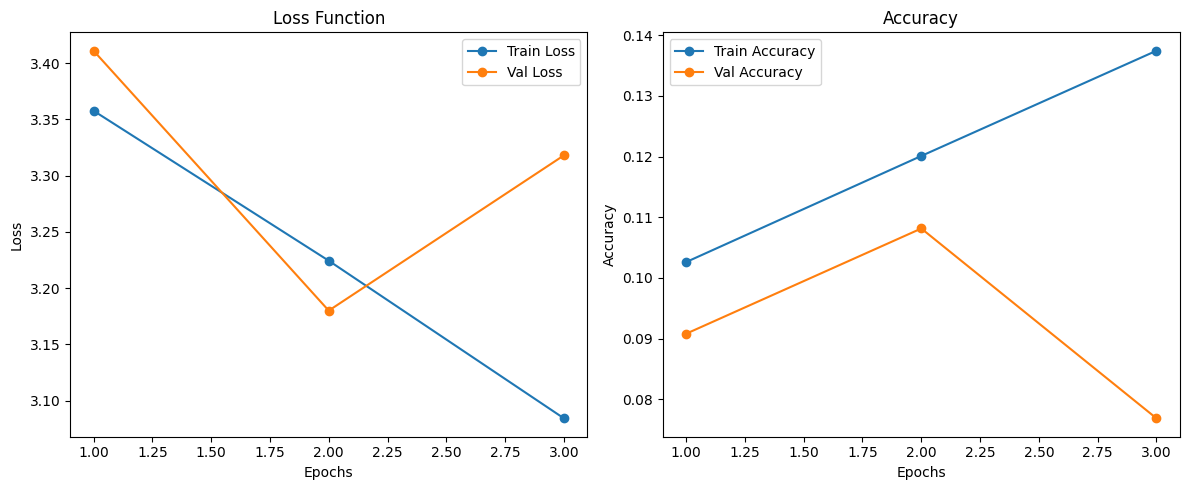

In [46]:
fit(epochs, baseline_model, loss_func, opt, train_dl, val_dl) #Måske gøre noget med batches_per_epoch=20?

### Visualize some predictions

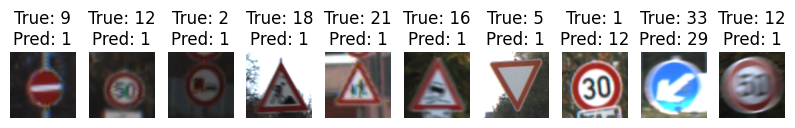

In [47]:
def denormalize(img):
    img = img / 2 + 0.5  # assuming the images were normalized to [-1, 1]
    return img.clamp(0, 1)  # clamp values to [0, 1]

# Modified show_images function with denormalization
def show_images(images, labels, preds, num_images=10):
    images = denormalize(images)  # Denormalize before displaying
    plt.figure(figsize=(10, 10))

    # Limit to the specified number of images (default is 5)
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Assuming images are in [C, H, W] format
        plt.title(f'True: {labels[i]}\nPred: {preds[i]}')
        plt.axis('off')
    plt.show()

# Get a batch of validation images
baseline_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = baseline_model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# Revert model back to training mode
baseline_model.train()

## Data augmentation

## Better model (batch normalization, dropout, bigger model)

In [48]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Dropout applied here for the dense layer

    nn.Linear(128, num_classes)
)

In [49]:
summary(model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─BatchNorm2d: 1-2                       [1, 16, 80, 80]           32
├─ReLU: 1-3                              [1, 16, 80, 80]           --
├─Conv2d: 1-4                            [1, 32, 40, 40]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 40, 40]           64
├─ReLU: 1-6                              [1, 32, 40, 40]           --
├─Conv2d: 1-7                            [1, 64, 20, 20]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 20, 20]           128
├─ReLU: 1-9                              [1, 64, 20, 20]           --
├─Conv2d: 1-10                           [1, 128, 10, 10]          73,856
├─BatchNorm2d: 1-11                      [1, 128, 10, 10]          256
├─ReLU: 1-12                             [1, 128, 10, 10]          --
├



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



### Train model

In [52]:
model.to(dev)
lr = 0.01
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

Epoch 1/15 - Train Loss: 2.5166, Train Acc: 0.2552 - Val Loss: 2.4275, Val Acc: 0.2511
Epoch 2/15 - Train Loss: 2.2564, Train Acc: 0.3068 - Val Loss: 2.1885, Val Acc: 0.3153
Epoch 3/15 - Train Loss: 1.9934, Train Acc: 0.3709 - Val Loss: 1.8101, Val Acc: 0.3828
Epoch 4/15 - Train Loss: 1.8527, Train Acc: 0.4026 - Val Loss: 1.9956, Val Acc: 0.4030
Epoch 5/15 - Train Loss: 1.7212, Train Acc: 0.4371 - Val Loss: 1.8111, Val Acc: 0.4033
Epoch 6/15 - Train Loss: 1.6635, Train Acc: 0.4533 - Val Loss: 1.6178, Val Acc: 0.4656
Epoch 7/15 - Train Loss: 1.5405, Train Acc: 0.4846 - Val Loss: 1.6577, Val Acc: 0.4817
Epoch 8/15 - Train Loss: 1.4350, Train Acc: 0.5368 - Val Loss: 1.3265, Val Acc: 0.5671
Epoch 9/15 - Train Loss: 1.2888, Train Acc: 0.5712 - Val Loss: 1.2154, Val Acc: 0.5916
Epoch 10/15 - Train Loss: 1.1464, Train Acc: 0.6235 - Val Loss: 1.0407, Val Acc: 0.6502
Epoch 11/15 - Train Loss: 0.9691, Train Acc: 0.6856 - Val Loss: 0.8277, Val Acc: 0.7174
Epoch 12/15 - Train Loss: 0.8364, Train A

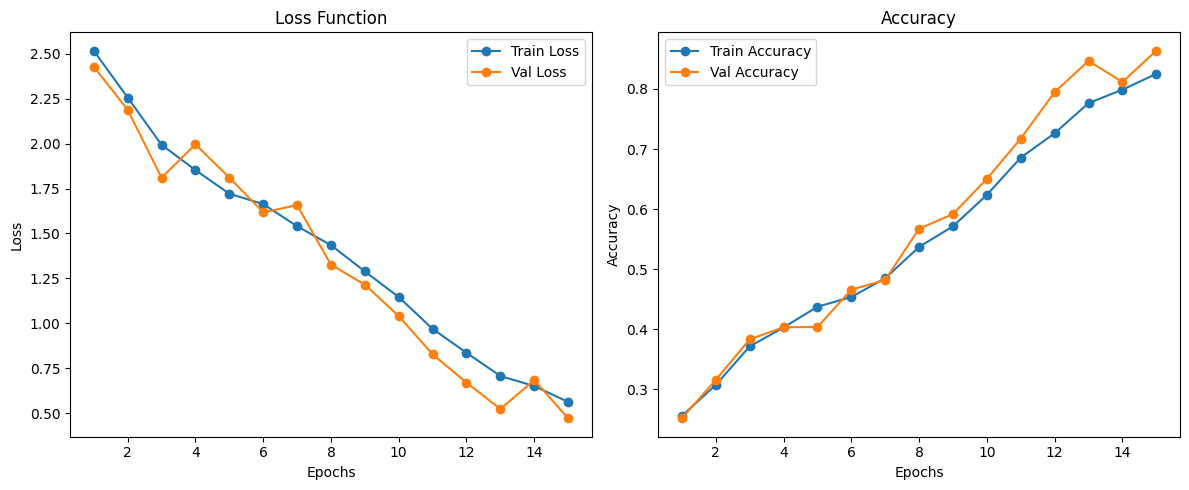

In [53]:
fit(epochs, model, loss_func, opt, train_dl, val_dl)

Clearly not done training.... Can just continue trainning by recalling fit like this (it remembers the weights it has learned from the training above).

```
fit(epochs, model, loss_func, opt, train_dl, val_dl)
```



### Visualize some predictions

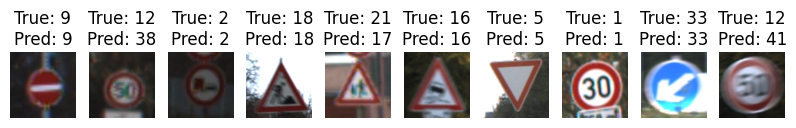

In [56]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# revert model back to train mode
model.train()

# Bayesian CNN



We will now also train a bayesian CNN. We will (for now) do it by doing Bayes by Backprop (BBB)

## Bayes by Backprop (BBB)

See chapter 5 in Enhancing deep learning with bayesian inference. Code for the example is given here: https://github.com/PacktPublishing/Enhancing-Deep-Learning-with-Bayesian-Inference/tree/main/ch05/bbb

(Maybe a library already exists so less code needed?)

# Adversiaral attack and/or out of distribution data

We in this section want to compare robustness of our CNN and bayesian our CNN against adversiaral attacks and/or out of distribtuion (OOD) data.

## Out of distribution data

Here we want to check what happens if we give our model for example a sign it hasn't seen before.

We want in the ideal case our CNN model to give same prob for each class, since it should reflect the uncertainty it has.

For the bayesian CNN we also want it for each sample of the posterior to give many different classes since it should be unsure about what this sign is.

## Adversiaral attack

Here we want to see how robust our models are if we make some
changes to the signs (think a damaged sign).